In [1]:
from prophet import Prophet
import pandas as pd
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/prophet_202110"

## Load Data From Files

In [3]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.392,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.392,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.392,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.203,...,-1.087,31.561,5.159e+10,4.979e+10,4.075e+10,3.661e+09,3.111e+09,2.546e+09,4259.604,4307.137
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.240,...,1.990,18.580,5.106e+10,5.205e+10,4.156e+10,3.780e+08,1.129e+09,9.018e+08,4276.202,4323.730
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.251,...,-2.312,14.723,5.245e+10,5.115e+10,4.060e+10,1.300e+09,2.674e+09,2.123e+09,4316.303,4337.489
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.262,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


## Fit Models Using All Data To Produce Final Forecast

In [4]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

def fit_final_forecast_model(foodprice_df, food_category, all_dates):
    train_df = get_prophet_df(foodprice_df, food_category, all_dates)       # Select data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    future = model.make_future_dataframe(periods=18, freq='MS')             # Create the future period. 
    forecast = model.predict(future.iloc[-18:])                             # Produce the future period forecast. 
    historical_fit = model.predict(future.iloc[:-18])                       # Look at how well the model fits the data.
    return model, forecast, historical_fit

In [5]:
def plot_final_forecast(model, forecast, historical_fit):

    fig = model.plot(forecast, figsize=(10,4))
    ax = fig.axes[0]

    ax.plot(historical_fit.ds, historical_fit.yhat, alpha=0.5, color='purple', label='Historical Model Fit')
    ax.fill_between(historical_fit.ds, historical_fit.yhat_lower, historical_fit.yhat_upper, 
                    alpha=0.2, color='purple', label='Historical Model Fit Uncertainty')
    ax.set_title(f'CPI Forecast - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_final_{food_category}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_final_{food_category}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.48525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1611.43    0.00705039       983.985           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1632.77    0.00173798       253.584      0.6431      0.6431      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1642.57    0.00179654       1204.64       0.413           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1648.42   9.31675e-05       302.049      0.1103      0.3723      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1657.17   0.000891583       181.552      0.2096           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha  

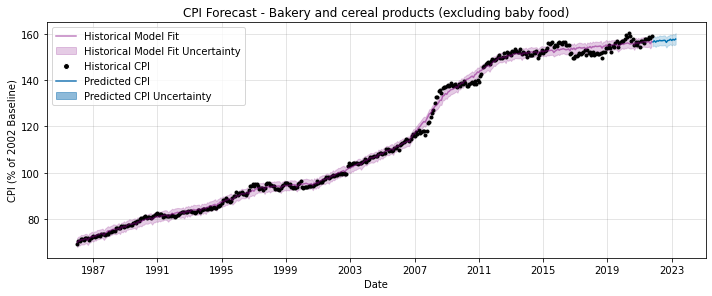

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.26367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1676.53     0.0101354        2541.8           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1691.17    0.00324965       461.668           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       1694.47   5.11687e-05       217.958   2.932e-07       0.001      362  LS failed, Hessian reset 
     299        1694.9    0.00279604       487.971           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359        1696.1   1.64458e-05       104.592   1.235e-07       0.001      498  LS failed, Hessian reset 
     399       1696.44   0.000247799       176.491      0.3328      0.3328      547   
    Iter      log pro

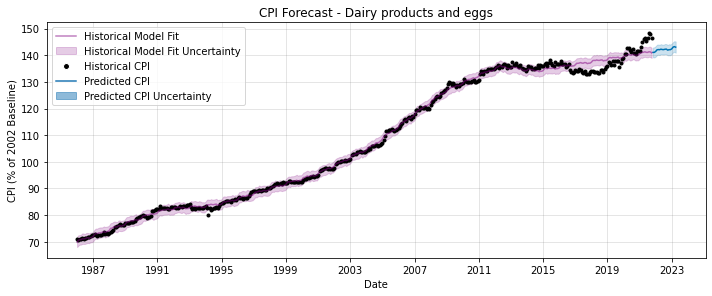

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.59942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1623.62     0.0185819       568.132           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1652.03   0.000708337       516.186      0.5236      0.5236      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1664.85    0.00362358       252.761           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1673.62   0.000820894       180.628      0.3117      0.3117      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1675.47   0.000660626       317.593           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

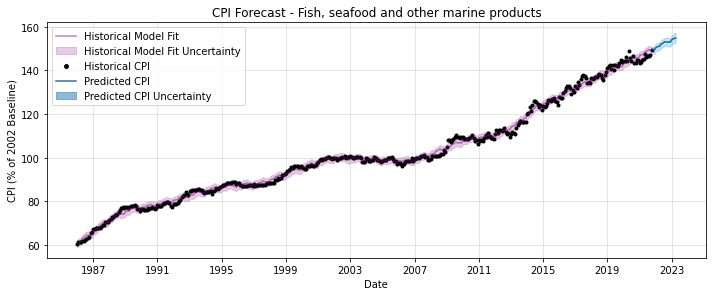

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38681
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1998.81   0.000679298       941.826      0.3703      0.3703      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2094.15     0.0092515       2372.05           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2147.67    0.00173972       5582.03       0.777       0.777      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2173.38    0.00166582        1922.3      0.4356           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2184.41    0.00926988        2720.5           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

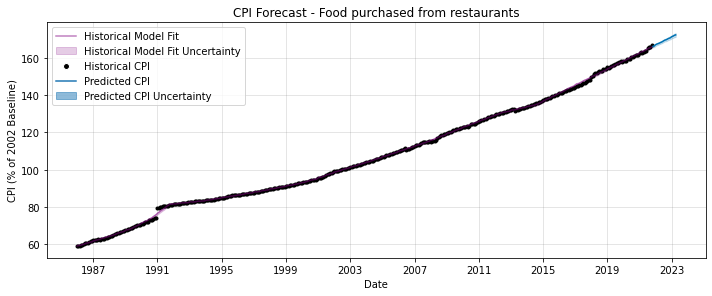

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1885.36      0.002855       573.877      0.9992      0.9992      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1905.08    0.00066216       219.412           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1910.11   0.000448528       390.874           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1911.44   0.000151922       187.884           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     494       1912.38    1.0225e-05       134.516   3.895e-08       0.001      636  LS failed, Hessian reset 
     499       1912.41   7.97875e-05    

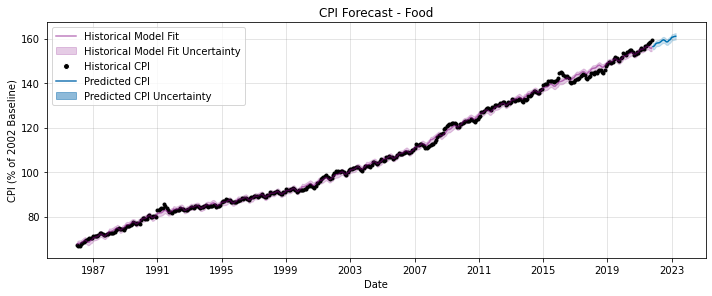

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.57264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.79     0.0276737       310.956      0.9807     0.09807      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.38   7.23402e-05       67.7708      0.4097           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.66   3.01131e-06        64.779      0.4536      0.4536      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       1372.52   8.65606e-05       111.331   4.505e-07       0.001      498  LS failed, Hessian reset 
     399       1372.58   0.000125733       66.2217           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       1372.61   2.63008e-05    

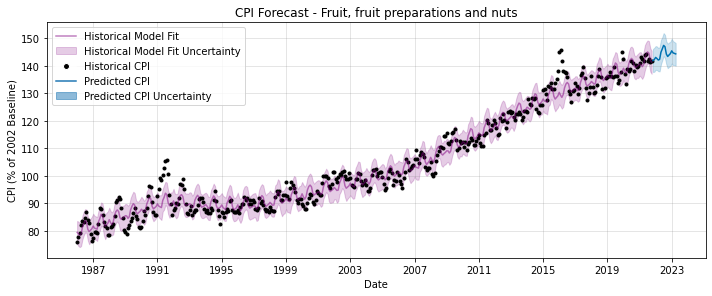

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.12951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1552.36     0.0133535       1063.92           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1566.47    0.00430655       435.773           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       1571.24   5.38952e-05       183.149   2.149e-07       0.001      388  LS failed, Hessian reset 
     299       1571.44    0.00254795       440.998           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       1572.25   3.69504e-05       71.1858   6.308e-07       0.001      501  LS failed, Hessian reset 
     399       1572.74    0.00170139       111.627      0.5086      0.5086      559   
    Iter      log pro

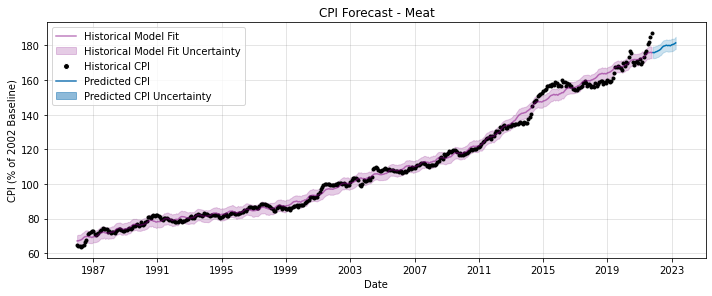

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1666    0.00386857       599.443      0.7253      0.7253      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1705.95    0.00263568       685.212           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1720.98   0.000105887       124.682           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1732.4    0.00018453       190.753      0.2165      0.9622      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1739.23   5.79649e-05       383.556      0.1663      0.1663      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

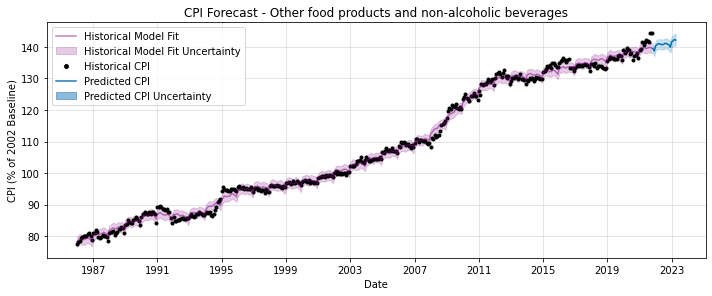

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.70353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1231.11     0.0046408        86.697        0.53           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       1232.39   0.000136043       89.6221   1.074e-06       0.001      235  LS failed, Hessian reset 
     181       1232.82   0.000113093       58.7811   2.031e-06       0.001      308  LS failed, Hessian reset 
     199       1232.91   0.000530144       63.9525           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       1233.04    0.00013458         102.1   1.279e-06       0.001      390  LS failed, Hessian reset 
     258       1233.08   6.05539e-06       61.0134   1.013e-07       0.001      487  LS failed, Hessian reset 
     299       1233.16   0.000609006        55.619      0.3468   

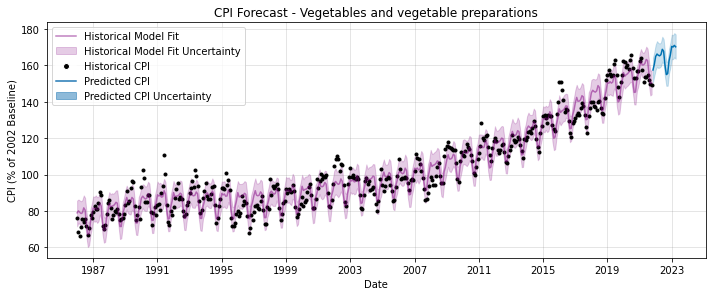

In [6]:
all_forecasts = {}

for food_category in foodprice_categories:

    model, forecast, historical_fit = fit_final_forecast_model(foodprice_df, food_category, all_dates=foodprice_df.index)
    plot_final_forecast(model, forecast, historical_fit)
    # forecast.to_csv(f"{output_path}/fc_final_{food_category}.csv")
    all_forecasts[food_category] = forecast

## Save final forecasts to file. 

In [7]:
all_forecasts_yhat = {}

for food_category, forecast_df in all_forecasts.items():
    all_forecasts_yhat[food_category] = forecast_df.yhat
    all_forecasts_yhat[food_category].index = pd.DatetimeIndex(forecast_df.ds)

final_forecast_df = pd.DataFrame(all_forecasts_yhat)
final_forecast_df.to_csv(f"{output_path}/fc_final.csv")
final_forecast_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
ds,,,,,,,,,
2021-11-01,156.525,141.058,149.521,166.120,156.443,141.889,175.891,139.527,157.427
2021-12-01,157.039,141.067,149.285,166.409,156.726,142.303,175.796,138.699,160.462
2022-01-01,156.428,141.414,150.360,167.039,157.645,143.079,176.254,140.368,164.862
2022-02-01,157.023,142.027,150.777,167.409,158.029,142.640,176.506,140.759,166.196
2022-03-01,156.874,142.122,151.048,167.632,158.085,142.141,176.904,141.045,165.564
2022-04-01,157.229,142.067,151.050,167.970,158.242,142.359,177.294,141.004,165.209
2022-05-01,157.055,142.264,152.090,168.299,158.694,144.946,177.965,140.793,165.867
2022-06-01,157.072,142.129,152.331,168.638,159.228,146.196,178.942,140.739,168.787
2022-07-01,157.199,142.103,152.786,169.108,159.489,147.451,179.569,140.804,167.775
